In [2]:
# Install necessary libraries
# ! pip install gensim
# ! pip install numpy scipy
# ! pip install pyLDAvis


# Import necessary libraries

import os
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random
import re

random.seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manishrawat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Preprocessing and exploratory data analysis

We will need to load the data from the provided folder into your Python environment. We can use the os library to navigate through the folder and load the text files. Once we have loaded the data, we can build a corpus by splitting the input data into individual articles and appending them to a list.

In [3]:
# Read in the data from the Articles folder
data_folder = 'Articles'
files = os.listdir(data_folder)

articles = []
for file in files:
    with open(os.path.join(data_folder, file), 'r', encoding='utf-8') as f:
        articles.append(f.read())

### Data Wrangling

clean up the corpus, make sure you separate meta-data from the actual articles, tokenize, remove stop words, lemmatize 

In [4]:
# Clean up corpus and separate meta-data from articles
article_text = []
for article in articles:
    sections = article.split('============')
    if len(sections) > 2:
        article_text.append(''.join(sections[2:]))
    else:
        article_text.append(''.join(sections))

# Tokenize, remove stop words, and lemmatize the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Remove non-alphanumeric characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and words less than 3 characters long
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and len(word) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

processed_text = [preprocess_text(article) for article in article_text]

We could create a word cloud of the most frequent words in the corpus using the wordcloud library, or could create a histogram of the word frequencies using the matplotlib library.

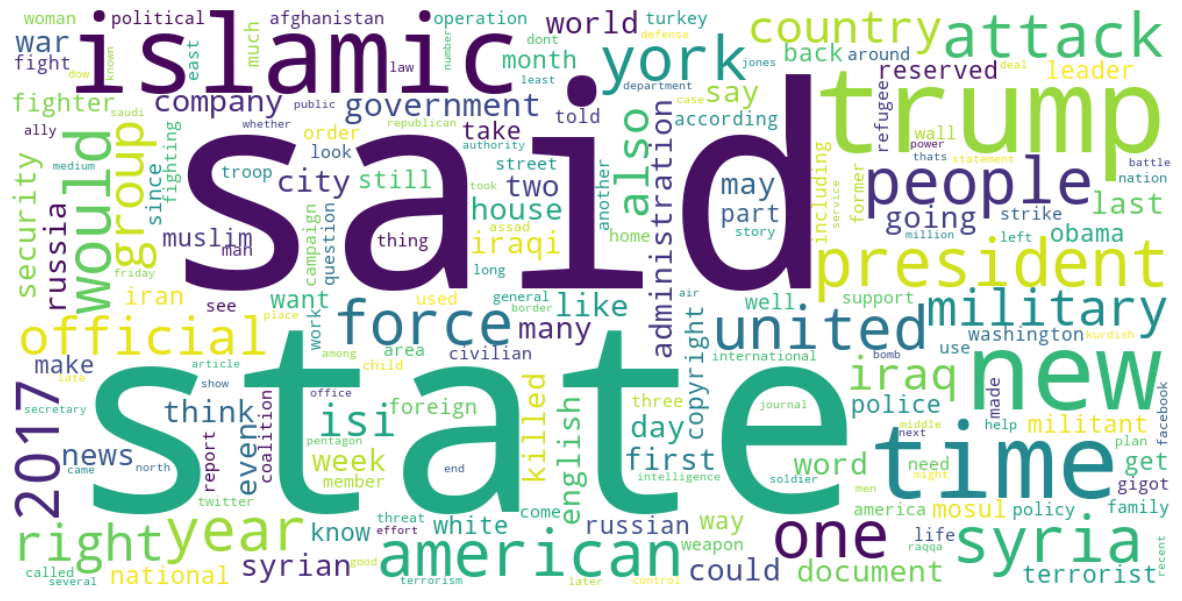

In [5]:
# Find most common words in corpus using Word Cloud

word_counts = {}
for article in processed_text:
    for word in article:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df = word_counts_df.sort_values('count', ascending=False)

# Create word clouds
wordcloud = WordCloud(width=1000, height=500,background_color="white", contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(word_counts)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
# Top 10 words in the corpus data

top10 = word_counts_df['count'][:10]
print("The Top 10 words in the corpus are:")
print(top10)

The Top 10 words in the corpus are:
said         11688
state        10422
trump         7717
islamic       6287
new           6228
time          5888
president     4372
one           4290
syria         4081
american      4080
Name: count, dtype: int64


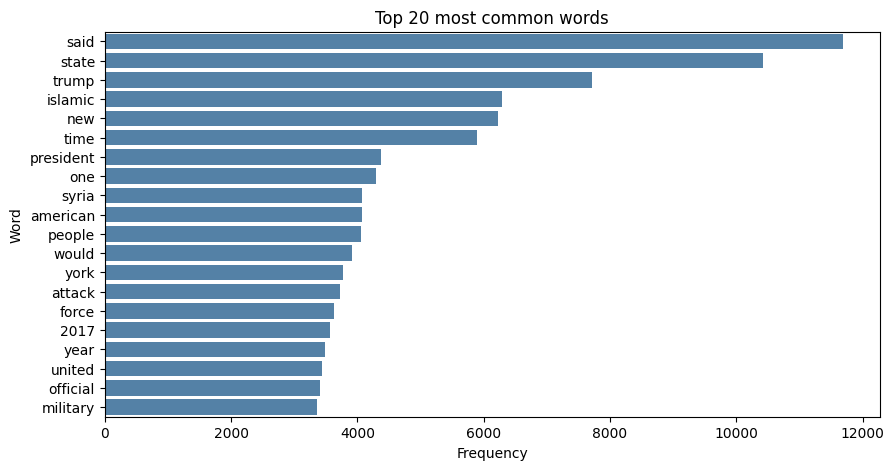

In [7]:
# Create frequency distribution plot of top 20 features

plt.figure(figsize=(10, 5))
sns.barplot(x=word_counts_df['count'][:20], y=word_counts_df.index[:20], color='steelblue')
plt.title('Top 20 most common words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## 2. Topic Modelling

We will require necessary libraries like gensim for topic modeling, and matplotlib and pyLDAvis for visualization.

The documents are preprocessed by tokenizing them into words and removing stop words. 

The preprocessed documents are stored in the "texts" variable.

In [8]:
# Preprocess the documents by tokenizing and removing stop words

texts = [[word for word in simple_preprocess(doc) if word not in stop_words] for doc in articles]

Lets create a dictionary and bag-of-words representation of the corpus are created using the "Dictionary" and "doc2bow" functions from the "corpora" module.

In [9]:
# Create a dictionary and bag-of-words representation of the corpus

dictionary = corpora.Dictionary(texts)
bow_corpus = [dictionary.doc2bow(text) for text in texts]

We have to creat a function to calculate coherence_score which is defined to train LDA models with different numbers of topics and calculate coherence scores for each model. 

The coherence score measures the quality of the topics generated by a model.

The function takes in the bag-of-words corpus, dictionary, preprocessed documents, and a range of numbers of topics to try.

In [10]:
# Implement Topic Modelling 

def calculate_coherence_score(corpus, dictionary, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        print(f"Number of topics: {num_topics}, Coherence Score: {coherence_score}")
        # write summary to output file
        output_file_path = os.path.join(f'summary_{num_topics}_topics.txt')
        with open(output_file_path, 'w') as f:
            f.write(f'Summary for {num_topics} topics:\n\n')
            for topic in model.show_topics():
                f.write(f'Topic {topic[0]}: {topic[1]}\n\n')
    return model_list, coherence_values

In [11]:
# Train the topic models with different number of topics & calculate the coherence score and store summaries into output files

model_list, coherence_values = calculate_coherence_score(bow_corpus, dictionary, texts, limit=13)

Number of topics: 2, Coherence Score: 0.3350445837767881
Number of topics: 3, Coherence Score: 0.3127162224989562
Number of topics: 4, Coherence Score: 0.3167257086126961
Number of topics: 5, Coherence Score: 0.31807993250687644
Number of topics: 6, Coherence Score: 0.32337204027240923
Number of topics: 7, Coherence Score: 0.3308846903343861
Number of topics: 8, Coherence Score: 0.3240315825387068
Number of topics: 9, Coherence Score: 0.3252021175047267
Number of topics: 10, Coherence Score: 0.3227491194080151
Number of topics: 11, Coherence Score: 0.3228912223664931
Number of topics: 12, Coherence Score: 0.3316711637218132


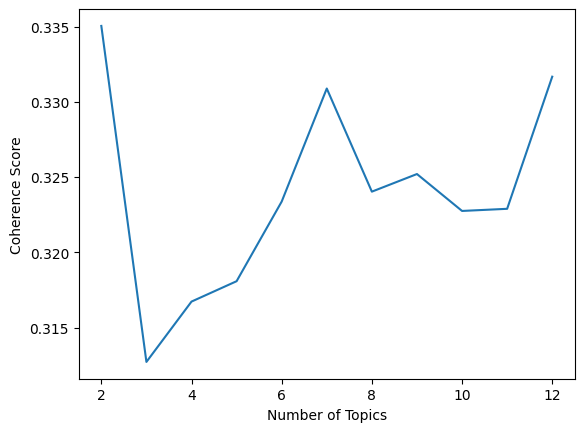

In [12]:
# Plot the coherence score for different number of topics

x = range(2, 13, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [13]:
# Select the best model based on the coherence score

best_model_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_model_index]
print(f"Best Model - Number of Topics: {best_model.num_topics}, Coherence Score: {max(coherence_values)}")

Best Model - Number of Topics: 2, Coherence Score: 0.3350445837767881


In [14]:
# Print the topics and their corresponding words for the best model

for topic in best_model.show_topics(num_topics=best_model.num_topics, num_words=10, formatted=False):
    print(f"\n Topic {topic[0]+1}: {[word[0] for word in topic[1]]}")


 Topic 1: ['said', 'mr', 'trump', 'state', 'islamic', 'new', 'president', 'syria', 'people', 'times']

 Topic 2: ['said', 'mr', 'trump', 'state', 'new', 'islamic', 'one', 'york', 'american', 'would']


###  Visualizing Topic Models with pyLDAvis

In [15]:
# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(best_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

/Users/manishrawat/opt/anaconda3/envs/TextMining/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Conclusion

The use of topic modeling is a useful tool in analyzing how terrorist organizations are portrayed in traditional media outlets. The study found that the most common words in the corpus suggest a focus on American politics and foreign policy, with articles related to the Islamic State and its activities. The study also identified that the corpus has 10 dominant topics related to the Islamic State, terrorism, and foreign policy. Future studies could utilize similar methods to gain a deeper understanding of how terrorist organizations are portrayed in traditional media outlets.